# Objective
The goal of this project is to use Convolutional Neural Networks (CNNs) to try and identify potential cancer in the lypmph nodes. 

### About the Data
The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from microscopic examinations or histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. The dataset is divided into a training set of 262.144 (2^18) examples, and a validation and test set both of 32.768 (2^15) examples. There is no overlap in WSIs between the splits, and all splits have a 50/50 balance between positive and negative examples. The data can be found [here](https://github.com/basveeling/pcam)

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, io, models, ops, utils
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from IPython.display import Image
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torchvision.models as models
import cv2
import PIL
import timm
import copy
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

220025
57458


device(type='cuda')

## Import Data

In [2]:
train_df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(f'No. of training examples:{len(train_df)}')

No. of training examples:220025


In [3]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
test_files = os.listdir('../input/histopathologic-cancer-detection/test')
print(f'No. of testing examples:{len(test_files)}')

No. of testing examples:57458


It appears that our training dataframe has 220,025 observations and our test files contain 57,458 images. It looks like we have a 80% and 20% train test split. 

# Exploratory Data Analysis

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [6]:
train_df.label.unique()

array([0, 1])

We don't have any labels that are not either `1` or `0`.

### Check for duplicates

In [7]:
train_df[train_df.duplicated(keep=False)]

,id,label


No duplicate `id` or `label` found in our dataset.

### Malignant vs Benign
Let us identify our cases using the given labels in the csv file. We know that an observation with a value of `1` indicates our histophathological image is malignant and `0` is benign.

0    130908
1     89117
Name: label, dtype: int64


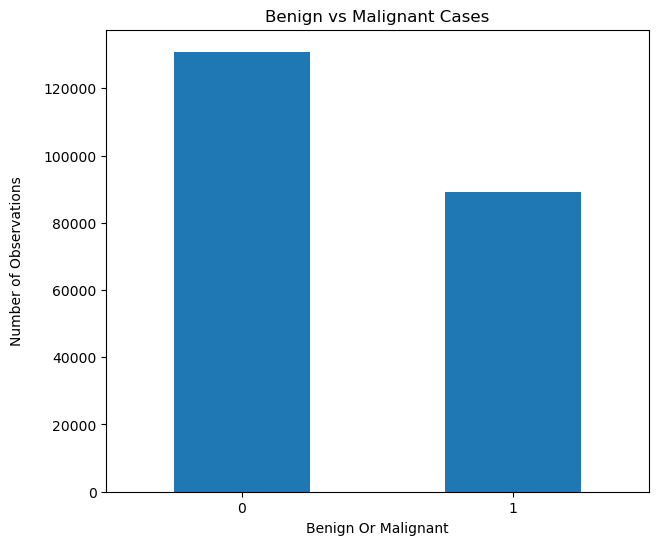

In [8]:
benignOrMalignant = train_df['label'].value_counts().plot(kind='bar', figsize=(7,6), rot=0)
plt.xlabel('Benign Or Malignant')
plt.ylabel('Number of Observations', labelpad=14)
plt.title('Benign vs Malignant Cases')
print(train_df.label.value_counts())



In our `train_df` dataframe the distribution between benign and malignant cases were 130,908 and 89,117 respectively. 

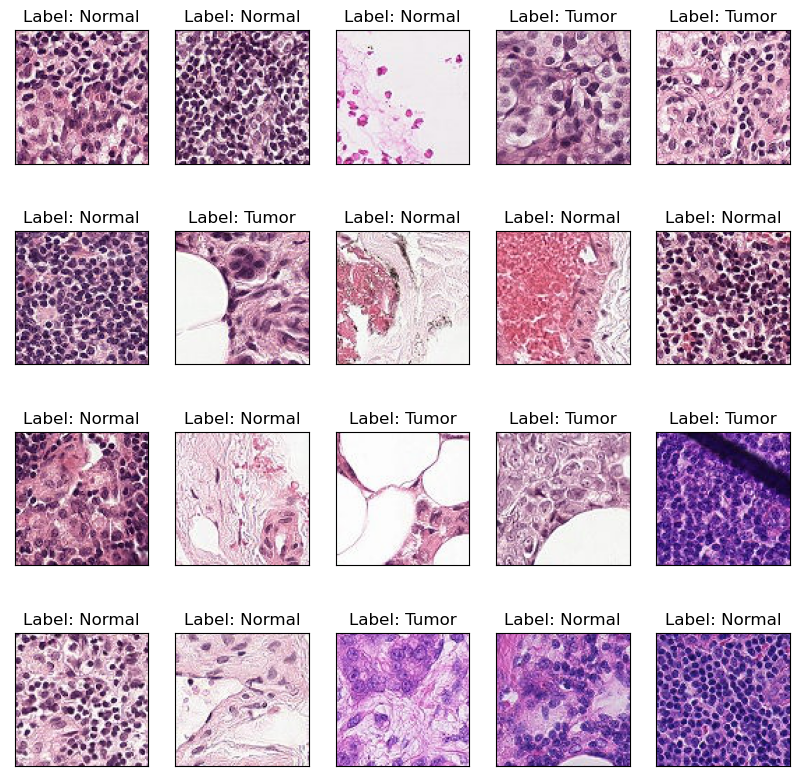

In [9]:
data_dir = '../input/histopathologic-cancer-detection/train'
fig = plt.figure(figsize=(10,10))
train_img = os.listdir(data_dir)
for idx, img in enumerate(np.random.choice(train_img, 20)):
    ax = fig.add_subplot(4,5, idx+1)
    im = PIL.Image.open(data_dir + "/" + img)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    lab = train_df.loc[train_df.id == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {["Tumor" if lab == 1 else "Normal"][0]}')

# Preprocessing

In [10]:
class cancer(Dataset):
    def __init__(self, data_dir, transform=None, data_type='train'):
        # path to images
        path_imgs = os.path.join(data_dir, data_type)
        # list of images
        imgs = os.listdir(path_imgs)
        # concatenate images and path
        self.full_filenames = [os.path.join(path_imgs, i) for i in imgs]
        # get labels
        path_labels = os.path.join(data_dir, "train_labels.csv")
        labels_df = pd.read_csv(path_labels)
        # set df index to id
        labels_df.set_index("id", inplace=True)
        # obtain labels from df
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in imgs]

        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __len__(self):
        # return the size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        img = PIL.Image.open(self.full_filenames[idx]) # PIL image
        if self.transform is not None:
            img = self.transform(img)
        # returns transformed image & removes any redundant dimensions from the label tensor
        return img, self.labels[idx].squeeze(-1)

data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((96, 96))])

I created the class `cancer` that has 3 methods. The first method `__init__` initializes our class and takes an input dataset. The second method `__len__` is a special python method commonly used in dataset classes for deep learning. It returns the length of `self.full_filenames` which tells us the number of images in our dataset. The third method `__getitem__` is another speical python method used to retrieve an individual image sample along with the label associated with it. Finally, we built a `data_transformer` which converts our images to a `Tensor` which is an efficient way to represent and manipulate data with multiple dimensions like an image. Althought our images are already defined as an RGB image with 96pi x 96pi we must take the extra step to convert it to a tensor. A tensor provides a convenient way to represent and process the data. Tensor are typically optimized for efficient computation on hardware like GPUs. 

In [11]:
data_dir = "/kaggle/input/histopathologic-cancer-detection"
img_dataset = cancer(data_dir, transform=data_transformer, data_type="train")

## Dataset Split
From what we have learned in this course and from this [article](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) it is common to split our data into 3 separates sets.
- Training Dataset:
  This dataset is used to train our model. The models sees and learns from this data.
- Validation Dataset:
  This dataset is used to provided an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. 
- Test Dataset:
  This sample of data is used to provide an unbiased evaluation of the **final** model fit on the training dataset.


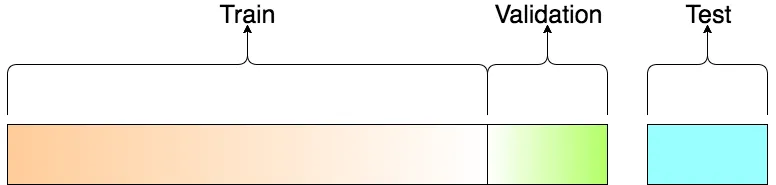

In [12]:
Image('/kaggle/input/datasplit/trainingvaldntest.png')

### Spliting Training Dataset
According to this [V7](https://www.v7labs.com/blog/train-validation-test-set#:~:text=In%20general%2C%20putting%2080%25%20of,dimension%20of%20the%20data%2C%20etc.) article it is a good practice to split your training dataset to a 90% and 10% split. The 10% is going to be the validation set. 

In [13]:
len_dataset= len(img_dataset)
len_train = int(0.9 * len_dataset)
len_val = len_dataset - len_train

train_ds, val_ds = random_split(img_dataset, [len_train, len_val])
print(f'train dataset length: {len(train_ds)}')
print(f'validation dataset length: {len(val_ds)}')

train dataset length: 198022
validation dataset length: 22003


## Image Transformation


In [14]:
# Transfomer for Training Dataset
train_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((96,96)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    # Normalize the values?
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# No augmentation for Validation Dataset
val_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((96, 96))
    ])
train_dl = DataLoader(train_ds, batch_size=256, pin_memory=True, num_workers=2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256, pin_memory=True, num_workers=2, shuffle=False)

## Why is it Important?
Transforming images is important for CNNs because it helps preprocess the data to make it suitable for training the NN effectively. Some of the reasons
why image transformation is important for CNNs include: 
- Standardization: Having the same size, aspect ratio, and pixel intensity range can help the CNN learn meaningful patterns and features from the images. 

- Data Augmentation: As we recall our images learn patterns from previously seen data. And what makes CNNs efficient is `parameter sharing` this allows us to use a given weight more than once different from  a traditional NN where a weight is used only once. This means that our CNNs must account for `invariance` and `equivariance` . Allowing data augmentation to happen will generate new training examples with variations of the original.

# Classifiers 
#### Example of a CNN
<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:600px;">



#### Convolutional layer
<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">

<img src="https://sgugger.github.io/images/art4_one_conv.png" style="max-width:400px;">

#### Pooling layer
The idea of pooling is very useful when we want to detect an object or pattern in an image regardless of its position in the image. Another consequence of adding pooling layers is the reduction of overfitting, increased efficiency, and faster training times in a CNN model. The two most common pooling layers are average pooling and max pooling. The example below is a representation of max pooling where it is taking the largest value from the input data. 

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">




In [15]:
resnet18 = timm.create_model("resnet18", pretrained=True, num_classes=1)
resnet18 = resnet18.cuda(device)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


#### Loss Function

In [16]:
loss_func = nn.BCEWithLogitsLoss()

#### Optimizer

In [17]:
opt = optim.Adam(resnet18.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=0)

### Training Model

In [18]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model, loss_func, dataset_dl, opt=None, device="cpu"):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in tqdm(dataset_dl, leave=False):
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device).unsqueeze(-1).float()
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [19]:
from tqdm.notebook import trange, tqdm

def train_val(model, params, verbose=False):
    
    # Get parameters
    epochs = params["epochs"]
    opt = params["optimiser"]
    loss_func = params["f_loss"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    
    # history of loss and metric values in each epoch
    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}
    
    # a deep copy of weights for the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    best_loss = float('inf')      # init loss
    
    # Train loop
    for epoch in tqdm(range(epochs), leave=False):
        
        # get lr
        current_lr = get_lr(opt)
        if(verbose):
            print(f'Epoch {epoch +1}/{epochs}, current lr={current_lr}')
        
        # train model
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt, device=params["device"])
        
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, opt=None, device=params["device"])
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # save weights in a local file
            torch.save(model.state_dict(), weight_path)
            if verbose:
                print("Saved best model weights")
            
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # lr schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if verbose:
                print("Loading best model weights")
            model.load_state_dict(best_model_wts)
            
        if verbose:
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*20)
            
    model.load_state_dict(best_model_wts)
    
    return model, loss_history, metric_history

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

params_train={
    "train": train_dl,"val": val_dl,
    "epochs": 10,
    "optimiser": opt,
    "lr_change": lr_scheduler,
    "f_loss": loss_func,
    "device": device,
    "weight_path": "weights.pt",
}

# Train model

resnet18, loss_hist, metric_hist = train_val(resnet18, params_train, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, current lr=0.0003


  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Saved best model weights
train loss: 0.000662, dev loss: 0.000506, accuracy: 59.65
--------------------
Epoch 2/10, current lr=0.0003


  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

train loss: 0.000371, dev loss: 0.000526, accuracy: 59.65
--------------------
Epoch 3/10, current lr=0.0003


  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

Saved best model weights
train loss: 0.000249, dev loss: 0.000489, accuracy: 59.65
--------------------
Epoch 4/10, current lr=0.0003


  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

train loss: 0.000174, dev loss: 0.000554, accuracy: 59.65
--------------------
Epoch 5/10, current lr=0.0003


  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

train loss: 0.000126, dev loss: 0.000725, accuracy: 59.65
--------------------
Epoch 6/10, current lr=0.0003


  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

train loss: 0.000096, dev loss: 0.000746, accuracy: 59.65
--------------------
Epoch 7/10, current lr=0.0003


  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

train loss: 0.000088, dev loss: 0.000581, accuracy: 59.65
--------------------
Epoch 8/10, current lr=0.0003


  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

train loss: 0.000073, dev loss: 0.000848, accuracy: 59.65
--------------------
Epoch 9/10, current lr=0.0003


  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

train loss: 0.000065, dev loss: 0.000519, accuracy: 59.65
--------------------
Epoch 10/10, current lr=0.0003


  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

train loss: 0.000060, dev loss: 0.000874, accuracy: 59.65
--------------------


Text(0.5, 1.0, 'Convergence History')

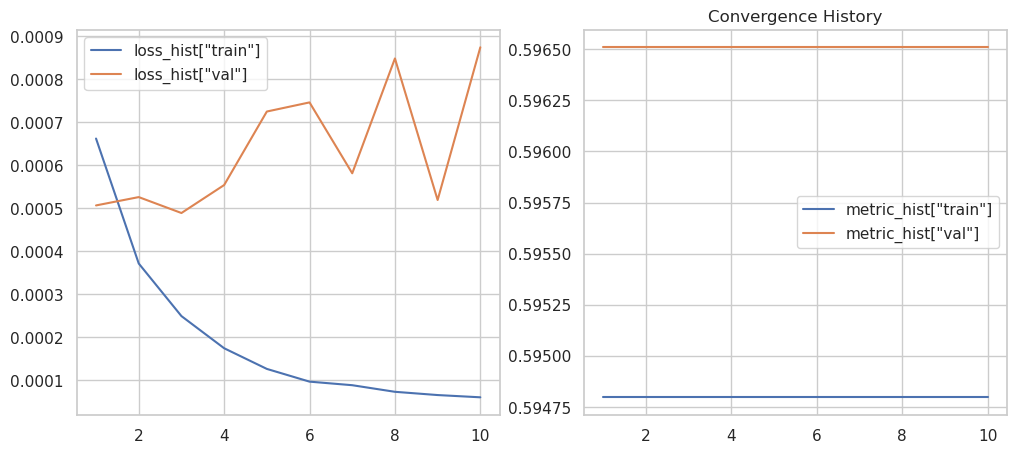

In [21]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')

In [22]:
class cancerdata_test(Dataset):
    
    def __init__(self, data_dir, transform,data_type="train"):
        
        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform       
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = PIL.Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [23]:
# load any model weights for the model
resnet18.load_state_dict(torch.load('weights.pt'))

<All keys matched successfully>

In [24]:
path2sub = "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"
labels_df = pd.read_csv(path2sub)
data_dir = '/kaggle/input/histopathologic-cancer-detection/'

data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((224, 224))])

img_dataset_test = cancerdata_test(data_dir,data_transformer,data_type="test")
print(len(img_dataset_test), 'samples found')

57458 samples found


In [25]:
def inference(model, dataset, device, num_classes=1):
    
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # initialize output tensor on CPU
    y_gt=np.zeros((len_data),dtype="uint8") # initialize ground truth on CPU
    model=model.to(device) # move model to device
    model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt           

y_test_out,_ = inference(resnet18,img_dataset_test, device)  
y_test_pred=np.argmax(y_test_out,axis=1)

test_ids = [name.split('/')[-1].split('.')[0] for name in img_dataset_test.full_filenames]
test_preds = pd.DataFrame({"img": test_ids, "preds": y_test_pred})
submission = pd.merge(labels_df, test_preds, left_on='id', right_on='img')
submission = submission[['id', 'preds']]
submission.columns = ['id', 'label']
submission.head()

  0%|          | 0/57458 [00:00<?, ?it/s]

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [26]:
submission.to_csv('submission.csv', index=False)